In [19]:
#%pip install python-crfsuite

In [20]:
import nltk
from nltk.tag import CRFTagger
nltk.download('conll2002')
from nltk.corpus import conll2002
from sklearn.metrics import f1_score, classification_report

tr_sp = conll2002.iob_sents('esp.train') # Train Español
dev_sp = conll2002.iob_sents('esp.testa') # Dev Español
test_sp = conll2002.iob_sents('esp.testb') # Test Español

tr_ne = conll2002.iob_sents('ned.train') # Train Neerlandés
dev_ne = conll2002.iob_sents('ned.testa') # Dev Neerlandés
test_ne = conll2002.iob_sents('ned.testb') # Test Neerlandés

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\baske\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [21]:
#print(tr_sp[0])
# Transformar: dejar solo (palabra, NER)
train_sents = [[(word, ner) for word, pos, ner in sent] for sent in tr_sp]
test_sents = [[(word, ner) for word, pos, ner in sent] for sent in test_sp]

In [22]:
ct = nltk.tag.CRFTagger()
ct.train(train_sents, 'esp_model.crf.tagger')
ct.set_model_file('esp_model.crf.tagger')

In [23]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])

In [24]:
#Accuracy a nivell de entitats, nms ens interesa saber si troba be les entitats, no totes les paraules
true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Calcular el F1 score (weighted)
f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)
print(f"F1 Score (weighted) sobre entidades: {f1:.2%}")

# També fem un report del reconeixament
print("\nReporte por clase:")
print(classification_report(true_entities, predicted_entities, zero_division=0))


F1 Score (weighted) sobre entidades: 70.38%

Reporte por clase:
              precision    recall  f1-score   support

       B-LOC       0.74      0.68      0.71      1084
      B-MISC       0.74      0.45      0.56       339
       B-ORG       0.78      0.81      0.79      1400
       B-PER       0.78      0.79      0.78       735
       I-LOC       0.60      0.54      0.57       325
      I-MISC       0.53      0.47      0.50       557
       I-ORG       0.79      0.79      0.79      1104
       I-PER       0.83      0.94      0.88       634
           O       0.00      0.00      0.00       277

    accuracy                           0.70      6455
   macro avg       0.64      0.61      0.62      6455
weighted avg       0.71      0.70      0.70      6455



# Amb el primer model simple obtenim una mica més d'un 70% de F1-Score sobre les entitats

Generem una matriu de confusió i una taula per observar quines etiquetes són les que el model millor prediu i quines les que menys. També 

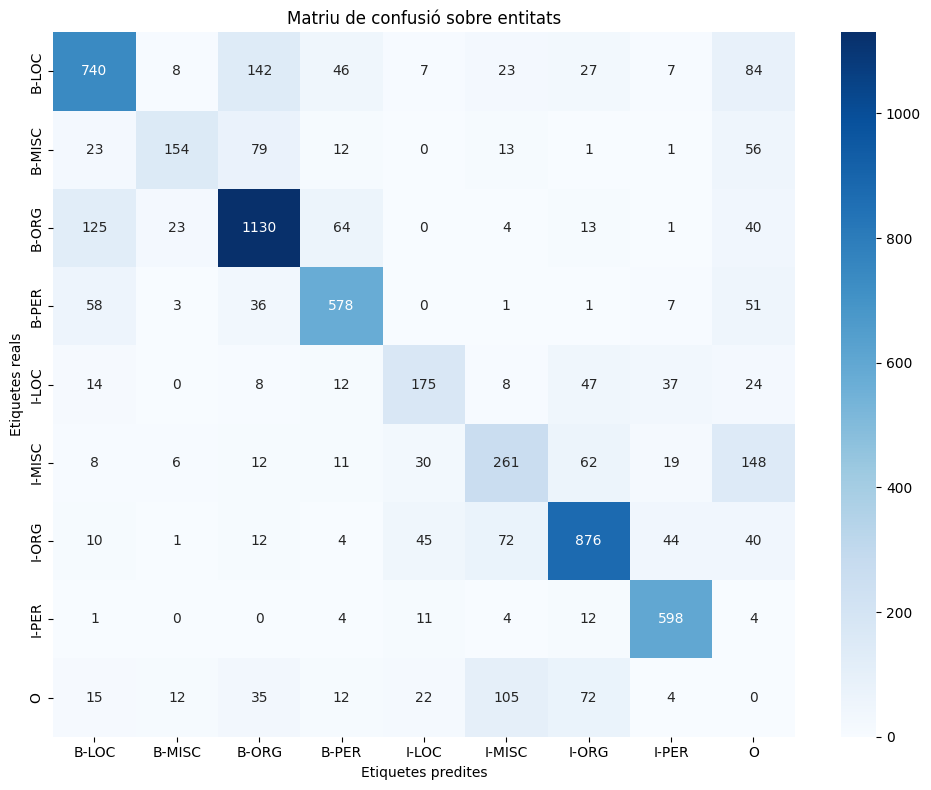

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
from sklearn.metrics import confusion_matrix

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

resultats = []
for i, label in enumerate(labels):
    correctes = cm[i, i]
    prediccions_totals = sum(cm[:, i])  # total de vegades que es va predir aquesta etiqueta
    errors = prediccions_totals - correctes
    percentatge = (correctes / prediccions_totals * 100) if prediccions_totals > 0 else 0.0
    resultats.append({
        'Etiqueta': label,
        'Correctes': correctes,
        'Errors': errors,
        '% d\'encerts': f"{percentatge:.2f}%"
    })

df_resultats = pd.DataFrame(resultats)
print(df_resultats)


  Etiqueta  Correctes  Errors % d'encerts
0    B-LOC        740     254      74.45%
1   B-MISC        154      53      74.40%
2    B-ORG       1130     324      77.72%
3    B-PER        578     165      77.79%
4    I-LOC        175     115      60.34%
5   I-MISC        261     230      53.16%
6    I-ORG        876     235      78.85%
7    I-PER        598     120      83.29%
8        O          0     447       0.00%


In [27]:
from collections import Counter

# Aplanem les etiquetes del conjunt de train
train_tags = [tag for sentence in train_sents for (_, tag) in sentence]

# Comptem les ocurrències de cada etiqueta
tag_counts = Counter(train_tags)

# Convertim a DataFrame i ordenem per freqüència
df_train_entities = pd.DataFrame(tag_counts.items(), columns=['Etiqueta', 'Freqüència'])
df_train_entities = df_train_entities.sort_values(by='Freqüència', ascending=False).reset_index(drop=True)

print(df_train_entities)

  Etiqueta  Freqüència
0        O      231920
1    B-ORG        7390
2    I-ORG        4992
3    B-LOC        4913
4    B-PER        4321
5    I-PER        3903
6   I-MISC        3212
7   B-MISC        2173
8    I-LOC        1891


Podem observar que les freqüències més altes en el train obtenen bons rendiments d'encerts. Però no en totes, doncs amb I-PER obtenim un 83% d'encerts.

Això ens fa pensar que afegint features podrem afegir més context i predir millor les entitats.

# Apliquem el mateix per al Neerlandés

F1 Score (weighted) sobre entidades (neerlandés): 63.11%

Reporte por clase (neerlandés):
              precision    recall  f1-score   support

       B-LOC       0.75      0.69      0.72       774
      B-MISC       0.80      0.60      0.68      1187
       B-ORG       0.78      0.60      0.68       882
       B-PER       0.67      0.73      0.70      1098
       I-LOC       0.44      0.37      0.40        49
      I-MISC       0.27      0.33      0.30       410
       I-ORG       0.60      0.57      0.58       551
       I-PER       0.76      0.91      0.83       807
           O       0.00      0.00      0.00       365

    accuracy                           0.62      6123
   macro avg       0.56      0.53      0.54      6123
weighted avg       0.66      0.62      0.63      6123



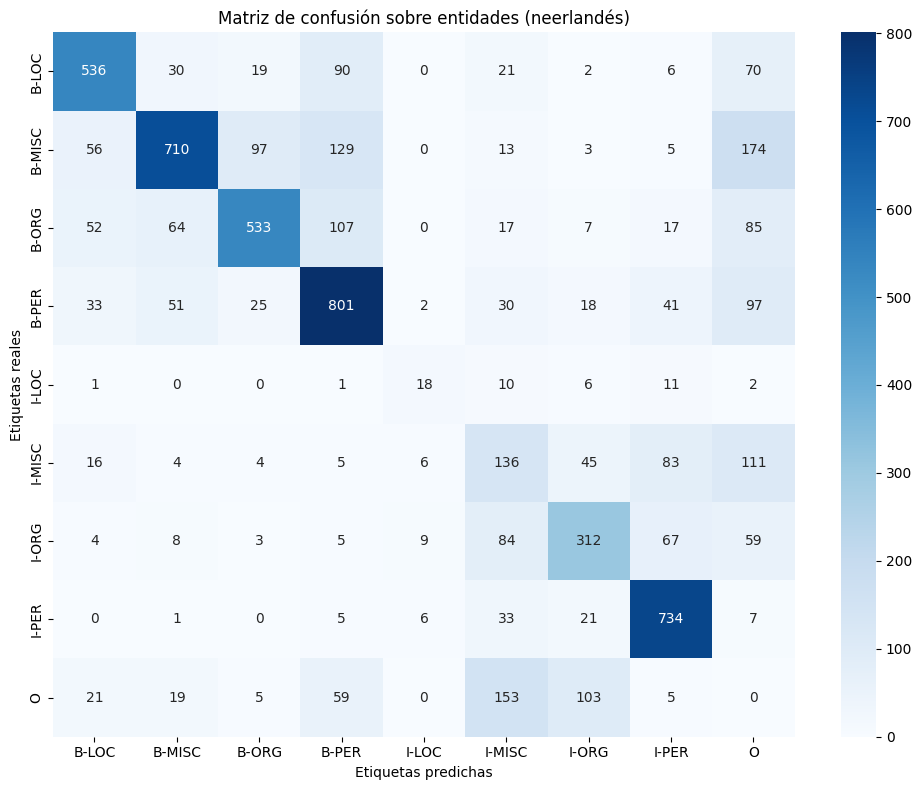


Rendiment per etiqueta:
  Etiqueta  Correctes  Errors % d'encerts
0    B-LOC        536     183      74.55%
1   B-MISC        710     177      80.05%
2    B-ORG        533     153      77.70%
3    B-PER        801     401      66.64%
4    I-LOC         18      23      43.90%
5   I-MISC        136     361      27.36%
6    I-ORG        312     205      60.35%
7    I-PER        734     235      75.75%
8        O          0     605       0.00%

Freqüència d'etiquetes en entrenament (neerlandés):
  Etiqueta  Freqüència
0        O      183346
1    B-PER        4716
2   B-MISC        3338
3    B-LOC        3208
4    I-PER        2883
5    B-ORG        2082
6   I-MISC        1405
7    I-ORG        1199
8    I-LOC         467


In [28]:

# Formato: solo (palabra, NER)
train_sents_ne = [[(word, ner) for word, pos, ner in sent] for sent in tr_ne]
test_sents_ne = [[(word, ner) for word, pos, ner in sent] for sent in test_ne]

# Entrenar modelo CRF para neerlandés
ct_ne = CRFTagger()
ct_ne.train(train_sents_ne, 'ned_model.crf.tagger')
ct_ne.set_model_file('ned_model.crf.tagger')

# Predecir en test
predicted_sents_ne = ct_ne.tag_sents([[word for word, tag in sent] for sent in test_sents_ne])

# Evaluación: solo entidades
true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents_ne, predicted_sents_ne):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O':
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# F1 Score sobre entidades
f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)
print(f"F1 Score (weighted) sobre entidades (neerlandés): {f1:.2%}")

# Reporte detallado
print("\nReporte por clase (neerlandés):")
print(classification_report(true_entities, predicted_entities, zero_division=0))

# Matriz de confusión
labels = sorted(set(true_entities + predicted_entities))
cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')
plt.title('Matriz de confusión sobre entidades (neerlandés)')
plt.tight_layout()
plt.show()

# Tabla de aciertos por etiqueta
resultats = []
for i, label in enumerate(labels):
    correctes = cm[i, i]
    prediccions_totals = sum(cm[:, i])
    errors = prediccions_totals - correctes
    percentatge = (correctes / prediccions_totals * 100) if prediccions_totals > 0 else 0.0
    resultats.append({
        'Etiqueta': label,
        'Correctes': correctes,
        'Errors': errors,
        '% d\'encerts': f"{percentatge:.2f}%"
    })

df_resultats = pd.DataFrame(resultats)
print("\nRendiment per etiqueta:")
print(df_resultats)

# Análisis de frecuencia en entrenamiento
train_tags_ne = [tag for sentence in train_sents_ne for (_, tag) in sentence]
tag_counts_ne = Counter(train_tags_ne)

df_train_entities_ne = pd.DataFrame(tag_counts_ne.items(), columns=['Etiqueta', 'Freqüència'])
df_train_entities_ne = df_train_entities_ne.sort_values(by='Freqüència', ascending=False).reset_index(drop=True)

print("\nFreqüència d'etiquetes en entrenament (neerlandés):")
print(df_train_entities_ne)


Com podem veure, en aquest cas el model amb Neerlandès ens dona un 63% en el F1-Score bastant pitjor que en el cas de l'espanyol tot i que també s'ha de tenir en compte que el nombre d'entitats d'entrenament és menor

# Exemples reals

In [29]:
sentence = ['Madrid', 'es', 'la', 'capital', 'de', 'España']
tagged = ct.tag(sentence)
print(tagged)

[('Madrid', 'B-LOC'), ('es', 'O'), ('la', 'O'), ('capital', 'O'), ('de', 'O'), ('España', 'B-LOC')]


In [30]:
sentence = ['Pablo', 'Chacón', 'va', 'a', 'aprobar', 'PLH']
tagged = ct.tag(sentence)
print(tagged)

[('Pablo', 'B-PER'), ('Chacón', 'I-PER'), ('va', 'O'), ('a', 'O'), ('aprobar', 'O'), ('PLH', 'B-ORG')]
